# ECE 445 (ML for ENGG): Credit Card Fraud Detection

*Eric Jiang ewj12 158002948*

12/14/2018

**This dataset contains transactions from European credit cards in September 2013.**

The variables are unknown due to confidentiality issues.

*The only known variables are:*

**Time** - Time it takes to reach final transaction

**Amount** - Amount in the transaction

**Class** - Determines if fraud (1) or non-fraud (0)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

B= '\033[1m'
E= '\033[0m'

In [2]:
#Import the CSV and display the header
dfo = pd.read_csv("creditcard.csv")
dfo.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


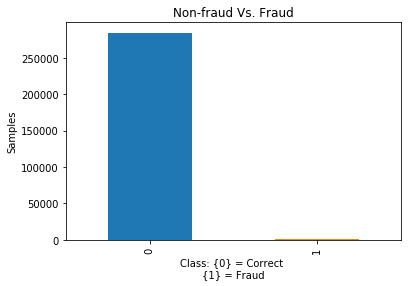

Number of Correct Samples: 284315
Number of Fraud Samples: 492
Ratio of Fraud to Correct: 0.0017304750013189597


In [3]:
#Portray the frequency of fraud
count_classes = pd.value_counts(dfo['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Non-fraud Vs. Fraud")
plt.xlabel("Class: {0} = Correct \n{1} = Fraud")
plt.ylabel("Samples")
plt.show()

correct = count_classes.tolist()[0]
fraud = count_classes.tolist()[1]
print(B+"Number of Correct Samples:"+E, correct)
print(B+"Number of Fraud Samples:"+E, fraud)
print(B+"Ratio of Fraud to Correct:"+E, fraud/correct)

**Since the # of fraud samples is only 0.17% of the dataset, the data needs to be undersampled for processing classifiers.** 


**Undersample the data (with 50% fraud and 50% non-fraud) to manipulate for PCA and graphing purposes**

*Creating a sub-sample will solve overfitting -* With most samples as non-fraud, the classifiers will assume that almost all cases are non-frauds leading to poor precision.

In [4]:
from sklearn.preprocessing import StandardScaler

# StandardScalar().fit_transform(X, y=None)
# fits data (computes mean and std) and transforms (by centering/scaling)
# X = training set with y as target value (typically none)

## STANDARDIZE THE DATA (TIME & AMOUNT) ##
dfo['normAmount'] = StandardScaler().fit_transform(dfo['Amount'].values.reshape(-1, 1))
df = dfo.drop(['Time','Amount'],axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


New undersampled sub-sample
Fraudulent samples: 492
Non-fraud samples: 492


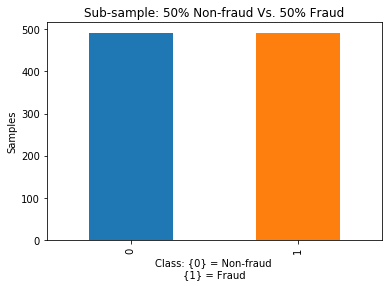

In [5]:
#Data
X = df.loc[:, df.columns != 'Class']

#Labels
Y = df.loc[:, df.columns == 'Class']

# Number of Fraud Records
frecs = len(df[df.Class == 1])

# Corresponding fraud indices in CSV
fi = np.array(df[df.Class == 1].index)

# Non-fruad indices in CSV
ni = df[df.Class == 0].index

# Create Array of random non-fraud indices with same size as fraud indices
ri = np.array(np.random.choice(ni, frecs, replace = False))

# Append the fraud indices with random non-fraud indices (50% fraud 50% non-fraud)
usd = np.concatenate([fi,ri])

# Under sampled dataset
usd = df.iloc[usd,:]

print(B+"New undersampled sub-sample"+E)
print(B+"Fraudulent samples:"+E, len(fi))
print(B+"Non-fraud samples:"+E, len(ri))

count_classes = pd.value_counts(usd['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Sub-sample: 50% Non-fraud Vs. 50% Fraud")
plt.xlabel("Class: {0} = Non-fraud \n{1} = Fraud")
plt.ylabel("Samples")
plt.show()

**Scramble the sub-sample and divide the data/class labels for training**

In [6]:
# Scramble the dataset so fraud isn't ordered first
usd = usd.sample(frac=1)

# Undersampled X data and Y labels via Class
Xu = usd.loc[:, usd.columns != 'Class'] 
Yu = usd.loc[:, usd.columns == 'Class'] # Yu == 1 then fraud otherwise 0

# Approach 1) K-Nearest Neighbor Classifier

**First obtain 2-D PCA of Data**

Create Training and Test sets for k-NN

In [7]:
#Optimize the train/test lengths (this uses 15% of data as test)
test_percent = .15
test_len = (np.floor(test_percent*len(Xu))).astype(int)
train_len = (len(Xu)-test_len).astype(int)

#Create Training Data
training_data = Xu[:train_len]
training_labels = Yu[:train_len]

#Create Test Data
test_data = Xu[train_len:]
test_labels = Yu[train_len:]

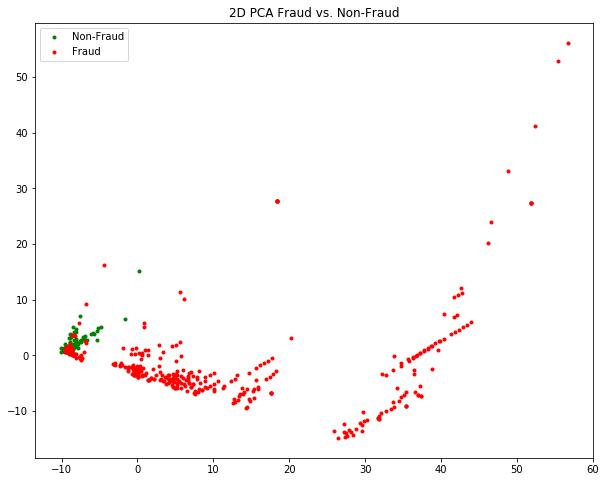

In [8]:
# Transpose the data matrix so each sample is a column
X = training_data.T

mean_vec = (np.sum(X, axis=1))/(X.shape[1])
mean_mat = np.tile(mean_vec.values.reshape(X.shape[0],1),[1,X.shape[1]])

#center the matrix
centered_X = X - mean_mat

#Singular Value Decomp centered matrix
U, s, Vh = np.linalg.svd(centered_X)

#Top 2 principal components of the centered data matrix
U2 = U[:,0:2]

#PCA features
X_tilde = U2.T@centered_X

#reconstruction
X_hat = U2@X_tilde + mean_mat

# Scatter plot for Fraud Vs. Non-Fraud
plt.figure(figsize=(10,8))
plt.scatter(X_tilde.T[np.where(training_labels==0),0],X_tilde.T[np.where(training_labels==0),1],c='g',marker='.',label='Non-Fraud')
plt.scatter(X_tilde.T[np.where(training_labels==1),0],X_tilde.T[np.where(training_labels==1),1],c='r',marker='.',label='Fraud')
plt.title('2D PCA Fraud vs. Non-Fraud')
plt.legend()
plt.show()

**From this 2D PCA plot, it seems that half of fraud can be seperated. However, a good portion is still within the same region as Non-fraud**

In [9]:
##### Find the 2D PCA features of test_data set #####

# Transpose the data matrix so each sample is a column
X = test_data.T

mean_vec = (np.sum(X, axis=1))/(X.shape[1])
mean_mat = np.tile(mean_vec.values.reshape(X.shape[0],1),[1,X.shape[1]])

#center the matrix
centered_X = X - mean_mat

#Singular Value Decomp centered matrix
U, s, Vh = np.linalg.svd(centered_X)

#Top 2 principal components of the centered data matrix
U2 = U[:,0:2]

#X_tilde1 = 2D PCA features of test_set
X_tilde1 = U2.T@centered_X

**Creating k-NN algorithm**

In [10]:
#Create class imagelabel(image = norm, label = 0,1)
#Use for knn to sort data as images based on norm while keeping its label
class imagelabel:
    def __init__(self, image, label):
        self.image = image
        self.label = label
    def __repr__(self):
        return repr((self.image, self.label))

#Create k-NN function to calculate the norms to the desired 'point'
#Using closest 'k' # of points to classify labels
def knn(point,k):
    #Create a matrix to store all the norm distances w/ labels
    norm_mat = []
    
    #Use the train_len pt of the training_data set
    for i in range (0,train_len):
        #Use X_tilde the 2D PCA features of training_data
        #Find norm between point and training set
        norm = np.linalg.norm(point-X_tilde.T[i])
        
        #append each (norm, label) using class imagelabel(norm,label)
        if training_labels.values[i] == 0: 
            norm_mat.append(imagelabel(norm,0))
        else:
            norm_mat.append(imagelabel(norm,1))
    
    #sort based on image's closest norms
    nmsort = sorted(norm_mat, key=lambda pt: pt.image)
    
    #Create counters to determine labels for k closest pts.
    counter0 = 0
    counter1 = 0
    
    #loop through k closest points
    for i in range (0,k):
        nms = nmsort[i]
        if nms.label == 0: #if label = 0 counter0++
            counter0+=1
        else:
            counter1+=1 #else label = 1 counter1++
    
    #output 0,1 label corresponding to highest counter
    if counter0 >= counter1:
        output = 0
    else:
        output = 1
    
    #return norm matrix, sorted norm matrix in order of closest to furthest pts, 0-1 output
    return norm_mat, nmsort, output

**Plotting k-NN Data with k = 5**

In [11]:
#create right/wrong 2D pts for plotting
xtright = []
ytright = []
xtwrong = []
ytwrong = []

#Counter for true/false frauds and non-frauds
tf = 0
tn = 0
ff = 0
fn = 0

#loop through the test_len to compare k-NN output to label
for i in range (0, test_len):
    nm, nm2, o = knn(X_tilde1.T[i],5)
    xn = X_tilde1.T[i,0]
    yn = X_tilde1.T[i,1]
    
    #if output = test_label then k-NN classified right
    #else classified wrong
    if o == test_labels.values[i]:
        xtright.append(xn) #append right pts for plot
        ytright.append(yn)
        #print('index',i, o, 'right')
        #Increment True counters accordingly
        if o == 1:
            tf+=1
        else:
            tn+=1
            
    else:
        xtwrong.append(xn) #append wrong pts for plot
        ytwrong.append(yn)
        #print('index:',i, o, 'wrong')
        #Increment False counters accordingly
        if o == 1:
            ff+=1
        else:
            fn+=1


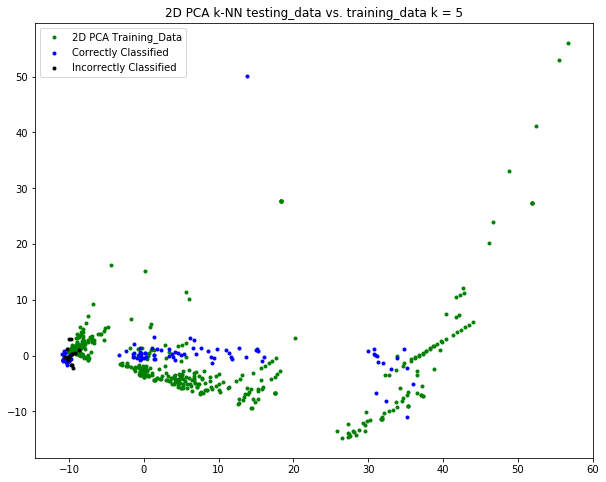

Error with k = 5: 0.11564625850340136


In [12]:
#Plotting on graph and displaying error

plt.figure(figsize=(10,8))
plt.scatter(X_tilde.T[:,0],X_tilde.T[:,1], color = 'green', marker = '.', label = '2D PCA Training_Data')
plt.scatter(xtright,ytright, color = 'blue', marker = '.', label = 'Correctly Classified')
plt.scatter(xtwrong,ytwrong, color = 'black', marker = '.', label = 'Incorrectly Classified')
plt.title('2D PCA k-NN testing_data vs. training_data k = 5')
plt.legend()
plt.show()

err = len(xtwrong)/test_len
print(B+'Error with k = 5:'+E, err)

## From 2-D PCA it is apparent that the outliers can be classified, but a decent amount of frauds are too close to non-frauds. This would lead to more false reports. 
## **To fix this issue, metrics from the binary matrix should be analyzed in depth.**

**The Recall metric would help determine the amount of false non-frauds (frauds that went undetected as innocent)**

**The Precision metric would help determine the amount of false frauds (innocent transactions that were mistakenly detected as fraud)**

*Recall* = True pos/(True pos + False neg)

*Recall* = True fraud/(True fraud + False non-fraud)

*Precision* = True pos/(True pos + False pos)

*Precision* = True fraud/(True fraud + False Fraud)

In [13]:
print(B+"True/False k-NN results"+E)
print("True Fraud =", tf)
print("True Non-fraud =", tn)
print("False Fraud =", ff)
print("False Non-fraud =", fn)

True/False k-NN results
True Fraud = 73
True Non-fraud = 57
False Fraud = 3
False Non-fraud = 14


**Define function to create and plot a binary confusion matrix**

In [14]:
import itertools

## Define function to plot matrix based on:
## [[True Non, False Fraud],[False Non, True Fraud]]

def plot_confusion_matrix(cm, title = 'Confusion Matrix'):
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuBuGn)
    plt.title(title)
    tick_marks = np.arange(len([0,1]))
    plt.xticks(tick_marks, ["Non-Fraud {0}","Fraud {1}"], rotation=0)
    plt.yticks(tick_marks, ["Non-Fraud {0}","Fraud {1}"])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()
    print(B+"Matrix Recall: "+E+ str(cm[1,1]/(cm[1,0] + cm[1,1])*100) +" %")
    print(B+"Matrix Precision: "+E+ str(cm[1,1]/(cm[1,1] + cm[0,1])*100) +" %")

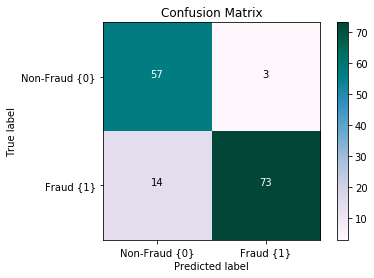

Matrix Recall: 83.9080459770115 %
Matrix Precision: 96.05263157894737 %


In [15]:
knncm = np.array([[tn,ff],[fn,tf]])
class_names = ["Non-Fraud {0}","Fraud {1}"]
plot_confusion_matrix(knncm)

Recall and precision affect each other inversely. Higher recall would lead to lower precision and vice versa.

Maximizing both is ideal, but Recall should be prioritized as it maximizes the detection of frauds (both real and fake). Whereas precision affects the rate of false alarms, an innocent result compared to the prior.

*Note: K-means centroid clustering may be a better solution to this problem due to the large variation of the given features.*

# Approach 2) Logistic Regression Classifier

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [17]:
def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(len(y_train_data),5,shuffle=False) 

    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    best_c = results_table
    best_c.dtypes.eq(object) # you can see the type of best_c
    new = best_c.columns[best_c.dtypes.eq(object)] #get the object column of the best_c
    best_c[new] = best_c[new].apply(pd.to_numeric, errors = 'coerce', axis=0) # change the type of object
    best_c
    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter'] #calculate the mean values
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [18]:
best_c = printing_Kfold_scores(training_data,training_labels)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.8764044943820225
Iteration  2 : recall score =  0.9367088607594937
Iteration  3 : recall score =  0.9529411764705882
Iteration  4 : recall score =  0.961038961038961
Iteration  5 : recall score =  0.92

Mean recall score  0.9294186985302131

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.8539325842696629
Iteration  2 : recall score =  0.8860759493670886
Iteration  3 : recall score =  0.9294117647058824
Iteration  4 : recall score =  0.8831168831168831
Iteration  5 : recall score =  0.9066666666666666

Mean recall score  0.8918407696252366

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.8764044943820225
Iteration  2 : recall score =  0.9113924050632911
Iteration  3 : 

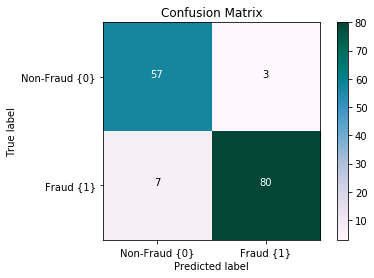

Matrix Recall: 91.95402298850574 %
Matrix Precision: 96.3855421686747 %


In [19]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(training_data,training_labels.values.ravel())
y_pred_undersample = lr.predict(test_data.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels,y_pred_undersample)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plot_confusion_matrix(cnf_matrix)


## Approach 3) Support Vector Machine Classifier

In [20]:
#Using the gaussian kernel to build the initail model. Let us see if this is the best parameter later
from sklearn.svm import SVC

classifier= SVC(C= 1, kernel= 'rbf', random_state= 0)
classifier.fit(training_data, training_labels.values.ravel())

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
#Predict the class using X_test
y_pred = classifier.predict(test_data)

In [22]:
#cm1 is the confusion matrix 1 which uses the undersampled dataset
cm1 = confusion_matrix(test_labels, y_pred)

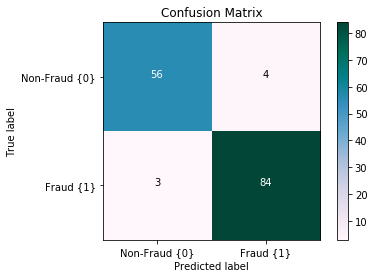

Matrix Recall: 96.55172413793103 %
Matrix Precision: 95.45454545454545 %


In [23]:
from sklearn.metrics import confusion_matrix
    
plot_confusion_matrix(cm1)


In [24]:
from sklearn.model_selection import cross_val_score

#Applying 10 fold cross validation
accuracies = cross_val_score(estimator = classifier, X=training_data, y = training_labels.values.ravel(), cv = 10)
mean_accuracy= accuracies.mean()*100
std_accuracy= accuracies.std()*100
print("The mean accuracy in %: ", accuracies.mean()*100)
print("The standard deviation in % ", accuracies.std()*100)
print("The accuracy of our model in % is betweeen {} and {}".format(mean_accuracy-std_accuracy, mean_accuracy+std_accuracy))

The mean accuracy in %:  92.24695420336809
The standard deviation in %  2.4106366684547886
The accuracy of our model in % is betweeen 89.8363175349133 and 94.65759087182288


In [25]:
from sklearn.model_selection import GridSearchCV

#applying gridsearchCV to our classifier
#Specifying the parameters in dictionaries to try out different parameters.
#The GridSearchCV will try all the parameters and give us the best parameters

parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(training_data, training_labels.values.ravel())
best_accuracy = grid_search.best_score_
print("The best accuracy using gridSearch is", best_accuracy)

best_parameters = grid_search.best_params_
print("The best parameters for using this model is", best_parameters)

The best accuracy using gridSearch is 0.9414575866188769
The best parameters for using this model is {'C': 100, 'kernel': 'linear'}


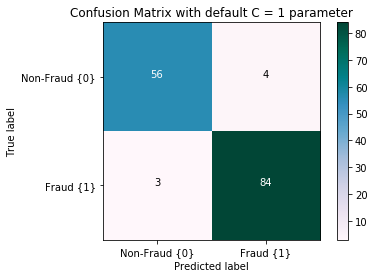

Matrix Recall: 96.55172413793103 %
Matrix Precision: 95.45454545454545 %


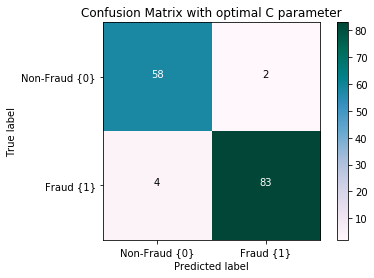

Matrix Recall: 95.40229885057471 %
Matrix Precision: 97.6470588235294 %


In [26]:
#fitting the model with the best parameters
classifier_with_best_parameters =  SVC(C= best_parameters["C"], kernel= best_parameters["kernel"], random_state= 0)
classifier_with_best_parameters.fit(training_data, training_labels.values.ravel())

#predicting the Class 
y_pred_best_parameters = classifier_with_best_parameters.predict(test_data)

#creating a confusion matrix
#cm2 is the confusion matrix  which uses the best parameters
cm2 = confusion_matrix(test_labels, y_pred_best_parameters)
#visualizing the confusion matrix

#matrix 1
plot_confusion_matrix(cm1, title = "Confusion Matrix with default C = 1 parameter")
plt.show()

#matrix 2
plot_confusion_matrix(cm2, title = "Confusion Matrix with optimal C parameter")
plt.show()

## Comparing the three sub-set Approaches with testing on the full Data Set

In [27]:
from sklearn.cross_validation import train_test_split

#Data
X = df.loc[:, df.columns != 'Class']

#Labels
Y = df.loc[:, df.columns == 'Class']

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.15, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

Number transactions train dataset:  242085
Number transactions test dataset:  42722
Total number of transactions:  284807


**Singular Vector Machine Matrix** 

SVM Classifier


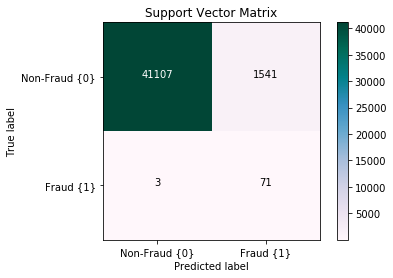

Matrix Recall: 95.94594594594594 %
Matrix Precision: 4.4044665012406945 %


In [28]:
# predicting y_pred_full_dataset
y_pred_full_dataset= classifier_with_best_parameters.predict(X_test)

# confusion matrix usign y_test_full and ypred_full
cm3 = confusion_matrix(y_test, y_pred_full_dataset)

print("SVM Classifier")
plot_confusion_matrix(cm3, "Support Vector Matrix")

In [29]:
# logistic regression
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(training_data,training_labels.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

In [30]:
# knn full dataset confusion matrix
from sklearn.neighbors import KNeighborsClassifier
classifier= KNeighborsClassifier(n_neighbors = 5)
classifier.fit(training_data, training_labels.values.ravel())

y_predknn = classifier.predict(X_test)
cm4 = confusion_matrix(y_test,y_predknn)

SVM Classifier


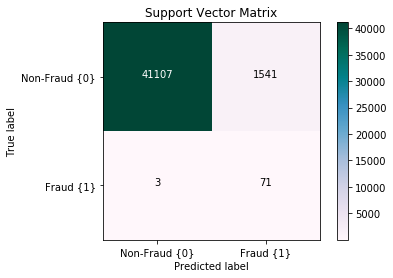

Matrix Recall: 95.94594594594594 %
Matrix Precision: 4.4044665012406945 %


In [31]:
print("SVM Classifier")
plot_confusion_matrix(cm3, "Support Vector Matrix")

Logistic Regression Classifier


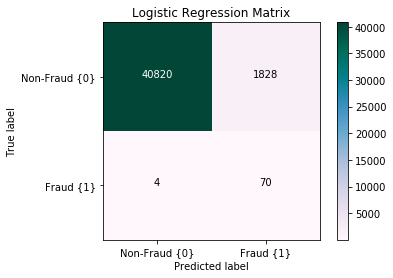

Matrix Recall: 94.5945945945946 %
Matrix Precision: 3.68809272918862 %


In [32]:
print("Logistic Regression Classifier")
plot_confusion_matrix(cnf_matrix, "Logistic Regression Matrix")

kNN Classifier


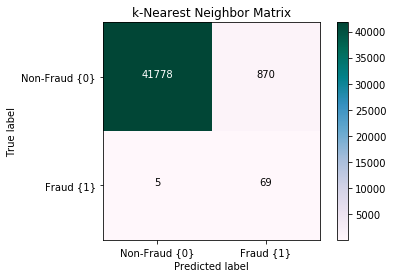

Matrix Recall: 93.24324324324324 %
Matrix Precision: 7.348242811501597 %


In [33]:
print("kNN Classifier")
plot_confusion_matrix(cm4, title = "k-Nearest Neighbor Matrix")

*In conclusion:*
1. SVM was the better model as it had the best recall (comparable to Logistic Regression) and precision. 
2. Logistic Regression was comparable to SVM as it had similar recall rates. 
    - However, SVM had the higher precision rate and thus was better than LR. Higher precision would lead to less false fraud alarms.
3. kNN was the worst model in terms of detecting fraud as it had the worst recall rate.
   - However, kNN had the highest precision rate leading to the best model in terms of reporting false fraud alarms.